In [1]:
import sys 
sys.path.append('/home/hous/Desktop/Generative AI/Generative_Deep_Learning_2nd_Edition/notebooks')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from scipy.stats import norm
import pandas as pd

from utils import display

In [3]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# Create a dataset from custom class
dataset = CelebADataset(root_dir="celeba-dataset/img_align_celeba/img_align_celeba", transform=transform)

# Create a data loader for batching and shuffling
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2  # Adjust as necessary
)

In [5]:
def sample_batch(data_loader):
    data_iter = iter(data_loader)
    batch = next(data_iter)
    if batch.is_cuda:
        batch = batch.cpu()
    return batch.numpy()

In [6]:
train_sample = sample_batch(train_loader)

In [7]:
train_sample

array([[[[1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        , ..., 0.8039216 ,
          0.7490196 , 0.7019608 ],
         [1.        , 1.        , 1.        , ..., 0.7411765 ,
          0.7411765 , 0.68235296],
         [1.        , 1.        , 1.        , ..., 0.7137255 ,
          0.67058825, 0.6745098 ]],

        [[1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        , ..., 0.5882353 ,
          0.53333336, 0.4

In [25]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if isinstance(images, torch.Tensor):  # Added this check to handle PyTorch tensors
        images = images.cpu().numpy()

    if images.ndim == 3:  # If it's a single image, expand dimensions to simulate a batch
        images = np.expand_dims(images, axis=0)
        
    if images.shape[1] in [1, 3]:  # Change (N, C, H, W) to (N, H, W, C) if needed
        images = np.transpose(images, (0, 2, 3, 1))

    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    print(f"Image shape before displaying: {images[0].shape}")  # Debug print

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

Image shape before displaying: (64, 64, 3)


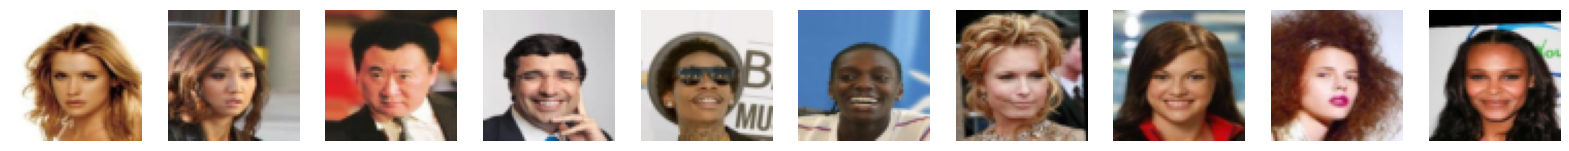

In [26]:
# Show some faces from the training set
display(train_sample, cmap=None)

In [10]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch, dim = z_mean.shape
        epsilon = torch.randn((batch, dim)).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, channels, num_features, z_dim):
        super(Encoder, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(channels, num_features, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features)
        self.lr1 = nn.LeakyReLU()

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(num_features, num_features, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features)
        self.lr2 = nn.LeakyReLU()

        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(num_features, num_features, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features)
        self.lr3 = nn.LeakyReLU()

        # Fourth Convolutional Layer
        self.conv4 = nn.Conv2d(num_features, num_features, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features)
        self.lr4 = nn.LeakyReLU()

        # Fifth Convolutional Layer
        self.conv5 = nn.Conv2d(num_features, num_features, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features)
        self.lr5 = nn.LeakyReLU()

        # Flatten Layer
        self.flatten = nn.Flatten()

        # Dense Layers for mean and log variance
        self.z_mean = nn.Linear(num_features * 2 * 2, z_dim)  # Adjust the dimensions accordingly
        self.z_log_var = nn.Linear(num_features * 2 * 2, z_dim)  # Adjust the dimensions accordingly

        # Sampling layer
        self.sampling = Sampling()

    def forward(self, x):
        x = self.lr1(self.bn1(self.conv1(x)))
        x = self.lr2(self.bn2(self.conv2(x)))
        x = self.lr3(self.bn3(self.conv3(x)))
        x = self.lr4(self.bn4(self.conv4(x)))
        x = self.lr5(self.bn5(self.conv5(x)))

        shape_before_flattening = x.shape[1:]

        x = self.flatten(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling(z_mean, z_log_var)

        return z_mean, z_log_var, z

In [13]:
from torchsummary import summary

# Instantiate the model
encoder = Encoder(CHANNELS, NUM_FEATURES, Z_DIM).to('cuda' if torch.cuda.is_available() else 'cpu')  # Move model to GPU if available

# Print the summary
summary(encoder, input_size=(CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          36,928
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         LeakyReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         LeakyReLU-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 64, 4, 4]          36,928
      BatchNorm2d-11             [-1, 64, 4, 4]             128
        LeakyReLU-12             [-1, 64, 4, 4]               0
           Conv2d-13             [-1, 64, 2, 2]          36,928
      BatchNorm2d-14             [-1, 6

In [14]:
class Decoder(nn.Module):
    def __init__(self, z_dim, num_features, channels):
        super(Decoder, self).__init__()

        self.dense = nn.Linear(z_dim, 2 * 2 * num_features)
        self.bn1 = nn.BatchNorm1d(2 * 2 * num_features)
        self.lr1 = nn.LeakyReLU()

        self.reshape = lambda x: x.view(-1, num_features, 2, 2)

        self.convT1 = nn.ConvTranspose2d(num_features, num_features, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(num_features)
        self.lr2 = nn.LeakyReLU()

        self.convT2 = nn.ConvTranspose2d(num_features, num_features, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(num_features)
        self.lr3 = nn.LeakyReLU()

        self.convT3 = nn.ConvTranspose2d(num_features, num_features, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(num_features)
        self.lr4 = nn.LeakyReLU()

        self.convT4 = nn.ConvTranspose2d(num_features, num_features, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(num_features)
        self.lr5 = nn.LeakyReLU()

        self.convT5 = nn.ConvTranspose2d(num_features, channels, kernel_size=3, stride=2, padding=1, output_padding=1)  # Adjusted the stride
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.lr1(self.bn1(self.dense(x)))

        x = self.reshape(x)

        x = self.lr2(self.bn2(self.convT1(x)))
        x = self.lr3(self.bn3(self.convT2(x)))
        x = self.lr4(self.bn4(self.convT3(x)))
        x = self.lr5(self.bn5(self.convT4(x)))
        x = self.output_activation(self.convT5(x))

        return x

In [15]:

# Instantiate the model
decoder = Decoder(Z_DIM, NUM_FEATURES, CHANNELS)

# If you have a GPU available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder = decoder.to(device)

# Print the summary with the expected input size
summary(decoder, input_size=(Z_DIM,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          51,456
       BatchNorm1d-2                  [-1, 256]             512
         LeakyReLU-3                  [-1, 256]               0
   ConvTranspose2d-4             [-1, 64, 4, 4]          36,928
       BatchNorm2d-5             [-1, 64, 4, 4]             128
         LeakyReLU-6             [-1, 64, 4, 4]               0
   ConvTranspose2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         LeakyReLU-9             [-1, 64, 8, 8]               0
  ConvTranspose2d-10           [-1, 64, 16, 16]          36,928
      BatchNorm2d-11           [-1, 64, 16, 16]             128
        LeakyReLU-12           [-1, 64, 16, 16]               0
  ConvTranspose2d-13           [-1, 64, 32, 32]          36,928
      BatchNorm2d-14           [-1, 64,

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, encoder, decoder, beta):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def compute_loss(self, x):
        z_mean, z_log_var, reconstruction = self.forward(x)
        reconstruction_loss = F.mse_loss(reconstruction, x, reduction='mean') * self.beta
        kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
        total_loss = reconstruction_loss + kl_loss
        return total_loss, reconstruction_loss, kl_loss


In [17]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter

# Create VAE, optimizer
vae = VAE(encoder, decoder, BETA).to(device)
optimizer = Adam(vae.parameters(), lr=LEARNING_RATE)

# TensorBoard writer
writer = SummaryWriter('./logs')

# Training loop
best_loss = float('inf')
for epoch in range(EPOCHS):
    vae.train()  # Set the model to training mode
    total_loss, recon_loss, kl_loss = 0, 0, 0
    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        loss, r_loss, k_loss = vae.compute_loss(batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        recon_loss += r_loss.item()
        kl_loss += k_loss.item()

    # Averaging the losses
    num_batches = len(train_loader)
    total_loss /= num_batches
    recon_loss /= num_batches
    kl_loss /= num_batches

    # Printing and logging the losses
    print(f"Epoch {epoch+1}: Total Loss: {total_loss}, Reconstruction Loss: {recon_loss}, KL Loss: {kl_loss}")
    writer.add_scalar('Total Loss', total_loss, epoch)
    writer.add_scalar('Reconstruction Loss', recon_loss, epoch)
    writer.add_scalar('KL Loss', kl_loss, epoch)

    # Save model if total loss improved
    if total_loss < best_loss:
        best_loss = total_loss
        torch.save(vae.state_dict(), './checkpoint/best_model.pth')
        print(f"Model saved with Total Loss: {best_loss}")

    # Generating Images after each epoch and save them
    vae.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        random_latent_vectors = torch.randn(10, Z_DIM).to(device)
        generated_images = vae.decoder(random_latent_vectors)
        save_image(generated_images, f"./output/generated_img_{epoch}.png", nrow=5, normalize=True)

# Closing the TensorBoard writer
writer.close()

2023-09-28 19:06:12.170108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 19:06:13.368995: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1: Total Loss: 39.95416985955784, Reconstruction Loss: 38.255208761874286, KL Loss: 1.6989611791363262
Model saved with Total Loss: 39.95416985955784
Epoch 2: Total Loss: 24.162064481820778, Reconstruction Loss: 22.204429718036856, KL Loss: 1.9576347418698945
Model saved with Total Loss: 24.162064481820778
Epoch 3: Total Loss: 21.23992005647622, Reconstruction Loss: 19.288681896592873, KL Loss: 1.951238149114598
Model saved with Total Loss: 21.23992005647622
Epoch 4: Total Loss: 19.4839514782364, Reconstruction Loss: 17.54409253921075, KL Loss: 1.9398589391762595
Model saved with Total Loss: 19.4839514782364
Epoch 5: Total Loss: 18.347294958648394, Reconstruction Loss: 16.43392609375154, KL Loss: 1.91336884102487
Model saved with Total Loss: 18.347294958648394
Epoch 6: Total Loss: 17.4692543352697, Reconstruction Loss: 15.584732307487098, KL Loss: 1.8845220445005184
Model saved with Total Loss: 17.4692543352697
Epoch 7: Total Loss: 16.826169986327237, Reconstruction Loss: 14.9750

In [23]:
# Get a batch of example images
example_images = next(iter(train_loader))

# If you need them as a numpy array, and move the channel dimension
example_images_np = example_images.numpy().transpose((0, 2, 3, 1)) 

Example real faces
Image shape before displaying: (64, 64, 3)


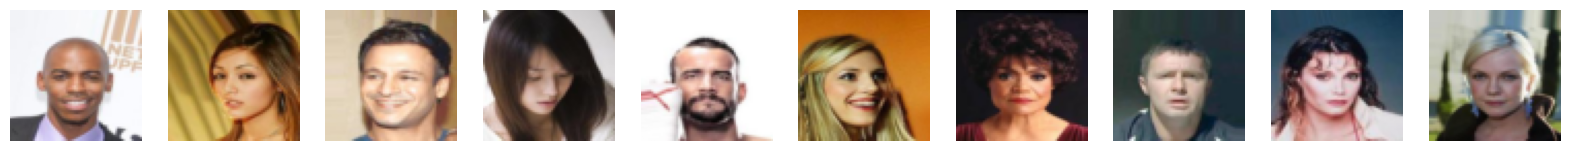

Reconstructions
Image shape before displaying: (64, 64, 3)


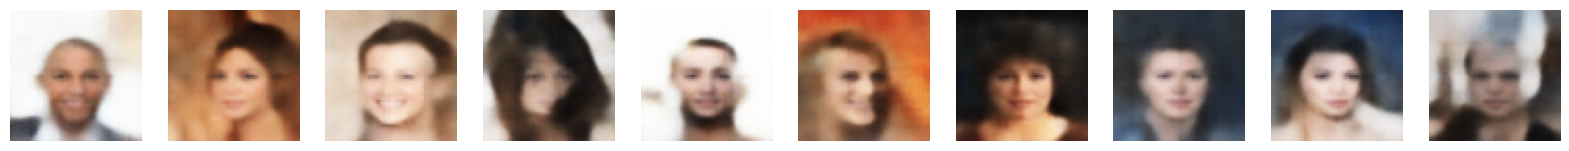

In [27]:
# Ensure the model is in evaluation mode
vae.eval()

# Get reconstructions
with torch.no_grad():  # No need to track gradients when evaluating
    example_images = example_images.to(device)  # Move images to device (GPU if available)
    z_mean, z_log_var, reconstructions = vae(example_images)

# Move the tensors back to the CPU for visualization
example_images = example_images.cpu()
reconstructions = reconstructions.cpu()

# If you need them as numpy arrays, also move the channel dimension
example_images_np = example_images.numpy().transpose((0, 2, 3, 1))
reconstructions_np = reconstructions.numpy().transpose((0, 2, 3, 1))

print("Example real faces")
display(torch.Tensor(example_images_np))  # Convert numpy array back to tensor for display
print("Reconstructions")
display(torch.Tensor(reconstructions_np))  # Convert numpy array back to tensor for display

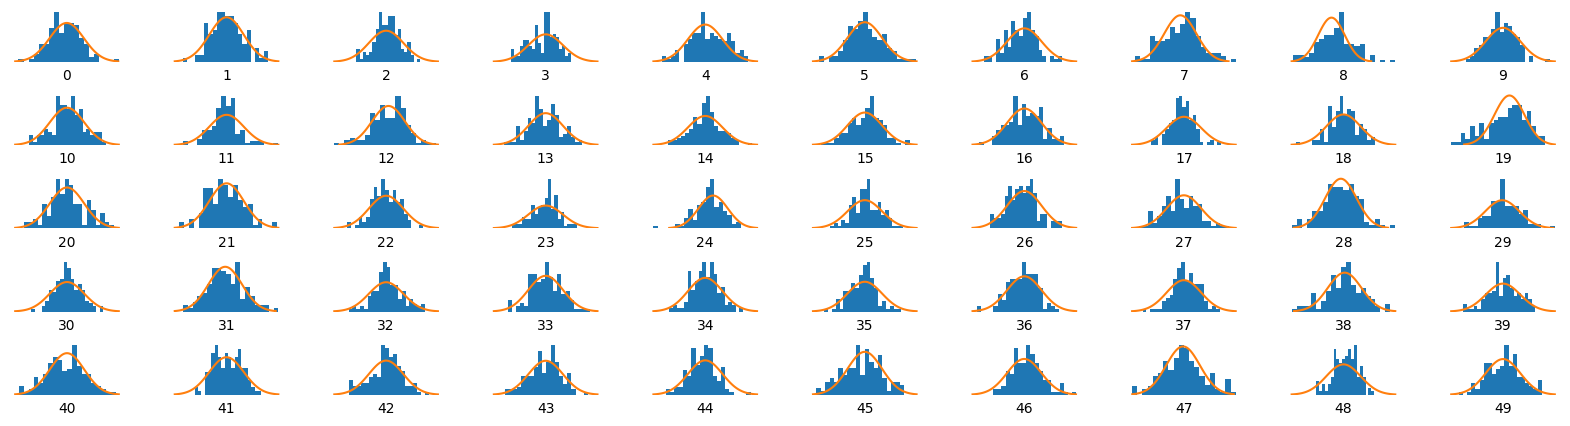

In [28]:
# Ensure the model is in evaluation mode
vae.eval()

# Get latent space
with torch.no_grad():  # No need to track gradients when evaluating
    example_images = example_images.to(device)  # Move images to device (GPU if available)
    _, _, z = vae.encoder(example_images)
    z = z.cpu().numpy()

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

In [29]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [30]:
# Ensure the model is in evaluation mode
vae.decoder.eval()

# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = torch.randn((grid_width * grid_height, Z_DIM), device=device)

# Decode the sampled points
with torch.no_grad():  
    reconstructions = vae.decoder(z_sample).cpu()

# If you need them as a numpy array, and move the channel dimension
reconstructions_np = reconstructions.numpy().transpose((0, 2, 3, 1))

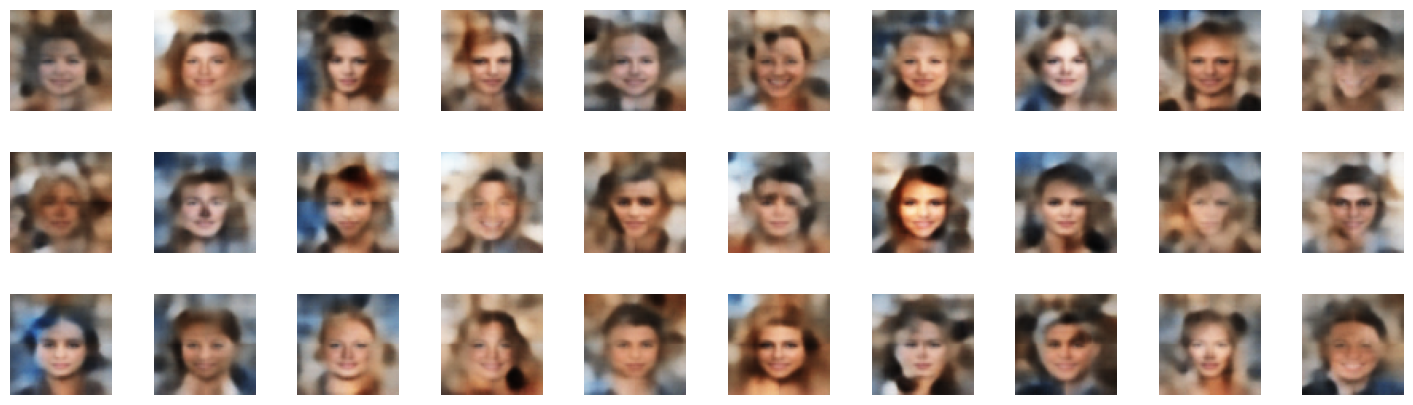

In [32]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions_np[i, :, :, :])